In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 721ms/step - loss: 0.0391
Average validation loss: 0.6169012784957886
4/4 [==============================] - 8s 738ms/step - loss: 0.0391 - val_loss: 0.6169
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 745ms/step - loss: 0.0277 - val_loss: 0.6169
Average validation loss: 0.5739068984985352
4/4 [==============================] - 11s 765ms/step - loss: 0.0277 - val_loss: 0.5954
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 681ms/step - loss: 0.0212 - val_loss: 0.5954
Average validation loss: 0.4306233823299408
4/4 [==============================] - 14s 693ms/step - loss: 0.0212 - val_lo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 714ms/step - loss: 2.4668e-05
Average validation loss: 0.0017129676416516304
8/8 [==============================] - 6s 724ms/step - loss: 2.4668e-05 - val_loss: 0.0017
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 687ms/step - loss: 2.4314e-05 - val_loss: 0.0017
Average validation loss: 3.557257377551082e-09
8/8 [==============================] - 11s 698ms/step - loss: 2.4314e-05 - val_loss: 8.5649e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 677ms/step - loss: 2.4049e-05 - val_loss: 8.5649e-04
Average validation loss: 1.9413408836044255e-07
8/8 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 694ms/step - loss: 6.6492e-05
Average validation loss: 0.04570516790105709
12/12 [==============================] - 8s 706ms/step - loss: 6.6492e-05 - val_loss: 0.0457
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 691ms/step - loss: 6.1533e-05 - val_loss: 0.0457
Average validation loss: 0.11514524595884268
12/12 [==============================] - 17s 703ms/step - loss: 6.1533e-05 - val_loss: 0.0804
Epoch 3/10
12/12 [==============================] - 25s 693ms/step - loss: 5.9359e-05 - val_loss: 0.0804
Average validation loss: 0.14818353741230794
12/12 [==============================] - 25s 703ms/step - loss: 5.9359e-05 - val_loss: 0.1030
Epoch 4/10
12/12 [==============================] - 34s 699ms/step - loss: 5.7501e-05 - val_loss: 0.1030
Average validation 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 703ms/step - loss: 2.8407e-05
Average validation loss: 0.23674208508495287
16/16 [==============================] - 11s 715ms/step - loss: 2.8407e-05 - val_loss: 0.2367
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 707ms/step - loss: 2.9876e-05 - val_loss: 0.2367
Average validation loss: 0.10862864208502288
16/16 [==============================] - 23s 717ms/step - loss: 2.9876e-05 - val_loss: 0.1727
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 720ms/step - loss: 2.9415e-05 - val_loss: 0.1727
Average validation loss: 0.023160893062595278
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 712ms/step - loss: 1.7871e-05
Average validation loss: 0.025764139601960778
20/20 [==============================] - 14s 723ms/step - loss: 1.7871e-05 - val_loss: 0.0258
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 697ms/step - loss: 1.6133e-05 - val_loss: 0.0258
Average validation loss: 0.08362389862813871
20/20 [==============================] - 29s 707ms/step - loss: 1.6133e-05 - val_loss: 0.0547
Epoch 3/10
20/20 [==============================] - 43s 730ms/step - loss: 1.5454e-05 - val_loss: 0.0547
Average validation loss: 0.026564180618152022
20/20 [==============================] - 43s 740ms/step - loss: 1.5454e-05 - val_loss: 0.0453
Epoch 4/10
20/20 [==============================] - 58s 706ms/step - loss: 1.4748e-05 - val_loss: 0.0453
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 736ms/step - loss: 2.6373e-05
Average validation loss: 0.025309128997226555
24/24 [==============================] - 18s 745ms/step - loss: 2.6373e-05 - val_loss: 0.0253
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 699ms/step - loss: 2.3251e-05 - val_loss: 0.0253
Average validation loss: 0.022958397554854553
24/24 [==============================] - 35s 711ms/step - loss: 2.3251e-05 - val_loss: 0.0241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 695ms/step - loss: 2.0896e-05 - val_loss: 0.0241
Average validation loss: 0.06386698285738628
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 763ms/step - loss: 5.8004e-05
Average validation loss: 0.07441181354224682
40/40 [==============================] - 31s 773ms/step - loss: 5.8004e-05 - val_loss: 0.0744
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 61s 753ms/step - loss: 4.9655e-05 - val_loss: 0.0744
Average validation loss: 0.12276826836168767
40/40 [==============================] - 62s 764ms/step - loss: 4.9655e-05 - val_loss: 0.0986
Epoch 3/10
40/40 [==============================] - 91s 738ms/step - loss: 4.5779e-05 - val_loss: 0.0986
Average validation loss: 0.17600083872675895
40/40 [==============================] - 92s 747ms/step - loss: 4.5779e-05 - val_loss: 0.1244
Epoch 4/10
40/40 [==============================] - 119s 695ms/step - loss: 4.2721e-05 - val_loss: 0.1244
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 765ms/step - loss: 3.6643e-05
Average validation loss: 0.027319531596731395
48/48 [==============================] - 37s 775ms/step - loss: 3.6643e-05 - val_loss: 0.0273
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 759ms/step - loss: 2.8523e-05 - val_loss: 0.0273
Average validation loss: 0.027965898606150102
48/48 [==============================] - 74s 770ms/step - loss: 2.8523e-05 - val_loss: 0.0276
Epoch 3/10
48/48 [==============================] - 111s 774ms/step - loss: 2.4165e-05 - val_loss: 0.0276
Average validation loss: 0.03362635031953687
48/48 [==============================] - 112s 784ms/step - loss: 2.4165e-05 - val_loss: 0.0296
Epoch 4/10
48/48 [==============================] - 149s 765ms/step - loss: 2.2635e-05 - val_loss: 0.0296
Average vali

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 703ms/step - loss: 3.6243e-05
Average validation loss: 0.03177459318456905
56/56 [==============================] - 40s 713ms/step - loss: 3.6243e-05 - val_loss: 0.0318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 695ms/step - loss: 2.5845e-05 - val_loss: 0.0318
Average validation loss: 0.021959617875316844
56/56 [==============================] - 79s 705ms/step - loss: 2.5845e-05 - val_loss: 0.0269
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 119s 700ms/step - loss: 2.2717e-05 - val_loss: 0.0269
Average validation loss: 0.0211978759367152
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 699ms/step - loss: 1.9798e-05
Average validation loss: 0.044469489104812965
64/64 [==============================] - 45s 709ms/step - loss: 1.9798e-05 - val_loss: 0.0445
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 694ms/step - loss: 1.3375e-05 - val_loss: 0.0445
Average validation loss: 0.04803729444756755
64/64 [==============================] - 91s 704ms/step - loss: 1.3375e-05 - val_loss: 0.0463
Epoch 3/10
64/64 [==============================] - 135s 699ms/step - loss: 1.0529e-05 - val_loss: 0.0463
Average validation loss: 0.06364117243720102
64/64 [==============================] - 136s 709ms/step - loss: 1.0529e-05 - val_loss: 0.0520
Epoch 4/10
64/64 [==============================] - 181s 707ms/step - loss: 9.1058e-06 - val_loss: 0.0520
Average valid

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 694ms/step - loss: 2.1594e-05
Average validation loss: 0.018790722203751404
72/72 [==============================] - 51s 704ms/step - loss: 2.1594e-05 - val_loss: 0.0188
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 703ms/step - loss: 1.5794e-05 - val_loss: 0.0188
Average validation loss: 0.014677566812477179
72/72 [==============================] - 102s 713ms/step - loss: 1.5794e-05 - val_loss: 0.0167
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 153s 702ms/step - loss: 1.2544e-05 - val_loss: 0.0167
Average validation loss: 0.14766214498215252
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 694ms/step - loss: 1.9886e-05
Average validation loss: 0.021095765312202273
80/80 [==============================] - 56s 704ms/step - loss: 1.9886e-05 - val_loss: 0.0211
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 112s 700ms/step - loss: 1.2633e-05 - val_loss: 0.0211
Average validation loss: 0.016587828751653433
80/80 [==============================] - 113s 709ms/step - loss: 1.2633e-05 - val_loss: 0.0188
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 169s 695ms/step - loss: 9.7965e-06 - val_loss: 0.0188
Average validation loss: 0.01984717745799571
80/80 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 66s 691ms/step - loss: 2.7608e-05
Average validation loss: 0.05456186202354729
96/96 [==============================] - 67s 701ms/step - loss: 2.7608e-05 - val_loss: 0.0546
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 134s 691ms/step - loss: 2.0438e-05 - val_loss: 0.0546
Average validation loss: 0.03595968196047276
96/96 [==============================] - 135s 701ms/step - loss: 2.0438e-05 - val_loss: 0.0453
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 201s 692ms/step - loss: 1.6134e-05 - val_loss: 0.0453
Average validation loss: 0.024996550690654356
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 83s 694ms/step - loss: 2.9007e-05
Average validation loss: 0.1636311832689292
120/120 [==============================] - 84s 703ms/step - loss: 2.9007e-05 - val_loss: 0.1636
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 701ms/step - loss: 2.2121e-05 - val_loss: 0.1636
Average validation loss: 0.6125176604194356
120/120 [==============================] - 170s 711ms/step - loss: 2.2121e-05 - val_loss: 0.3881
Epoch 3/10
120/120 [==============================] - 254s 702ms/step - loss: 2.0247e-05 - val_loss: 0.3881
Average validation loss: 0.04059711614002784
120/120 [==============================] - 255s 711ms/step - loss: 2.0247e-05 - val_loss: 0.2722
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segf

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 100s 696ms/step - loss: 1.4097e-05
Average validation loss: 0.013690588607763251
144/144 [==============================] - 102s 706ms/step - loss: 1.4097e-05 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 202s 698ms/step - loss: 9.4711e-06 - val_loss: 0.0137
Average validation loss: 0.012794458617766699
144/144 [==============================] - 204s 708ms/step - loss: 9.4711e-06 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 304s 695ms/step - loss: 7.5530e-06 - val_loss: 0.0132
Average validation loss: 0.01316603221413162
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 700ms/step - loss: 7.9431e-06
Average validation loss: 0.009257392975268886
160/160 [==============================] - 114s 710ms/step - loss: 7.9431e-06 - val_loss: 0.0093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 710ms/step - loss: 5.5589e-06 - val_loss: 0.0093
Average validation loss: 0.01094267814187333
160/160 [==============================] - 229s 720ms/step - loss: 5.5589e-06 - val_loss: 0.0101
Epoch 3/10
160/160 [==============================] - 342s 706ms/step - loss: 4.3462e-06 - val_loss: 0.0101
Average validation loss: 0.009073870704742148
160/160 [==============================] - 343s 716ms/step - loss: 4.3462e-06 - val_loss: 0.0098
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 704ms/step - loss: 2.5923e-05
Average validation loss: 0.028398293177597223
200/200 [==============================] - 143s 714ms/step - loss: 2.5923e-05 - val_loss: 0.0284
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 704ms/step - loss: 1.8291e-05 - val_loss: 0.0284
Average validation loss: 0.01014326032716781
200/200 [==============================] - 286s 715ms/step - loss: 1.8291e-05 - val_loss: 0.0193
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 427s 705ms/step - loss: 1.4368e-05 - val_loss: 0.0193
Average validation loss: 0.011588800768367945
200/200 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:47 - loss: 2.1996e-06

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 701ms/step - loss: 1.4399e-05
Average validation loss: 0.0277332394849509
240/240 [==============================] - 171s 710ms/step - loss: 1.4399e-05 - val_loss: 0.0277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 339s 703ms/step - loss: 1.1010e-05 - val_loss: 0.0277
Average validation loss: 0.05135675047834714
240/240 [==============================] - 342s 713ms/step - loss: 1.1010e-05 - val_loss: 0.0395
Epoch 3/10
240/240 [==============================] - 510s 701ms/step - loss: 8.9338e-06 - val_loss: 0.0395
Average validation loss: 0.024606185718099974
240/240 [==============================] - 512s 711ms/step - loss: 8.9338e-06 - val_loss: 0.0346
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.07799894925650804, 0.06389733712263691, 0.15139506723310284, 0.12985905061592173, 0.07802946274928922, 0.05620918282263952, 0.05395005616435702, 0.03334192206964986, 0.03814258786789228, 0.03200767164351714, 0.03690825911580443, 0.03317929095601355, 0.04115446912490825, 0.05083947747093849, 0.017920763657625433, 0.014488883134727076, 0.013555117595117192, 0.014138702779398877]
std_val_losses =  [0.1466502641256545, 0.059725896529919636, 0.21227524011390725, 0.10751238301435448, 0.05599864354333538, 0.05022300241891215, 0.07564543493930315, 0.025483726426241266, 0.038615487404475825, 0.04985169264841135, 0.05800905227707408, 0.04227863476138881, 0.04057563146094208, 0.09330555699043275, 0.019174042315280068, 0.009453788728404345, 0.007192106325726447, 0.008238766726472847]


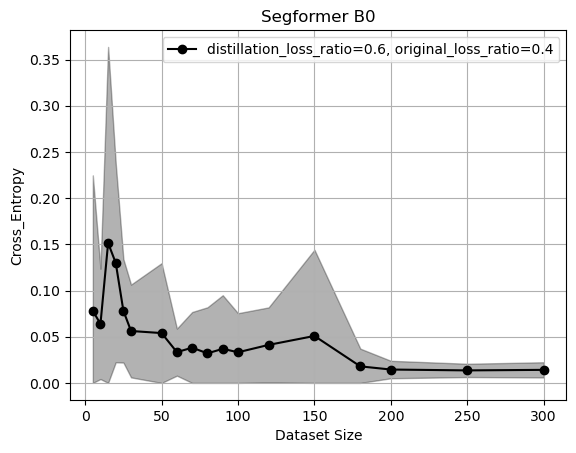

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()